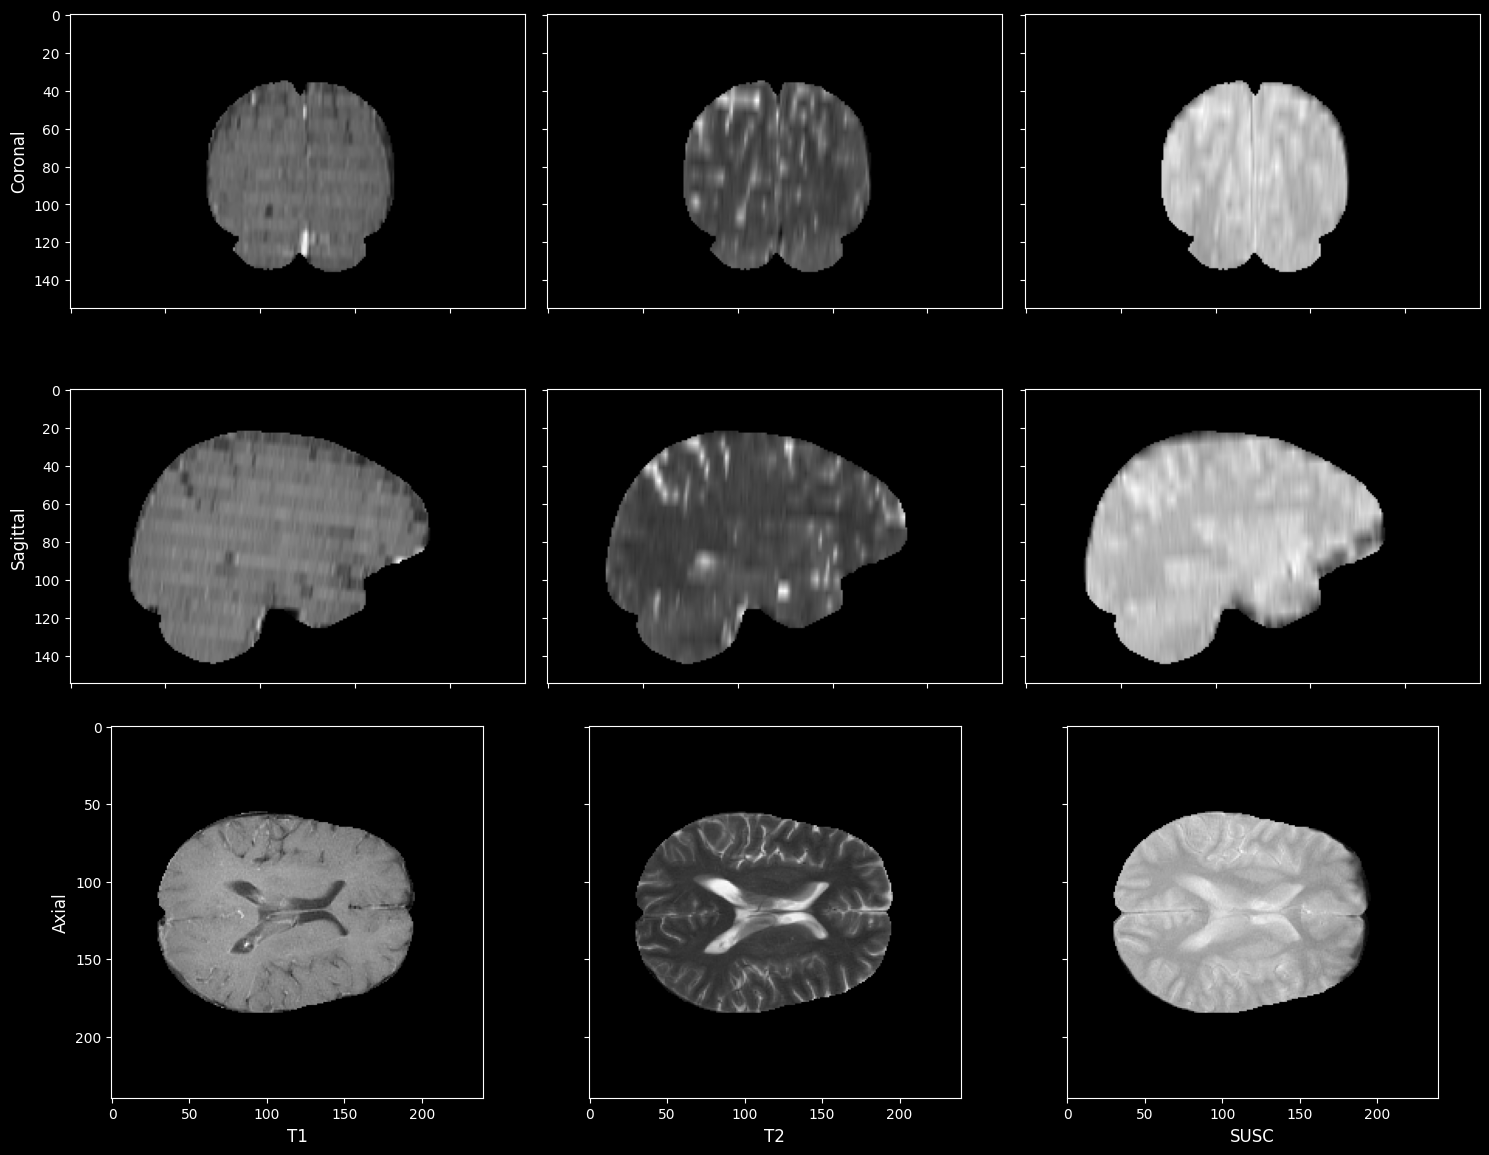

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import os
import nibabel as nib

PATH = "/home/mariopasc/Python/Datasets/Meningiomas/meningioma"
PATIENT = "P40"
PULSES = ["T1", "T2", "SUSC"]
OUTPUT_PATH = "/home/mariopasc/Python/Datasets/Meningiomas/meningioma"

suf = "_registered_sri24"
suf = ""

data = {}
for pulse in PULSES:
    file = os.path.join(PATH, PATIENT, f"{pulse}_{PATIENT}"+suf+".nii.gz")
    seg = os.path.join(PATH, PATIENT, f"{pulse}_{PATIENT}_seg"+suf+".nii.gz")
    img = nib.load(file)
    seg = nib.load(seg)

    data[pulse] = {
        "vol_path": file,
        "seg_path": seg,
        "vol": img.get_fdata(),
        "seg": seg.get_fdata(),
    }

# Visualize data with pulses as columns and views as rows in specific order
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
# Don't call plt.subplots_adjust here - we'll do it after tight_layout
fig.patch.set_facecolor('black')

# Define specific slice indices
sagittal_slice = 80
coronal_slice = 50
axial_slice = 150
# Row titles (now in specific order: coronal, axial, sagittal)
view_titles = ["Coronal", "Sagittal", "Axial"]

# Display each pulse in columns
for col, pulse in enumerate(PULSES):
    vol = data[pulse]["vol"]
    seg = data[pulse]["seg"]

    # Coronal view (top row)
    axes[0, col].imshow(np.rot90(vol[:, coronal_slice]), cmap='gray')
    axes[0, col].imshow(np.rot90(np.ma.where(seg[:, coronal_slice] == 1, 1, np.nan)), cmap='Reds_r', alpha=0.5)
    axes[0, col].axis('on')
    axes[0, col].tick_params(axis='both', colors='white')
    for spine in axes[0, col].spines.values():
        spine.set_color('white')
    
    # Axial view (middle row)
    axes[1, col].imshow(np.rot90(vol[axial_slice]), cmap='gray')
    axes[1, col].imshow(np.rot90(np.ma.where(seg[axial_slice] == 1, 1, np.nan)), cmap='Reds_r', alpha=0.5)
    axes[1, col].axis('on')
    axes[1, col].tick_params(axis='both', colors='white')
    for spine in axes[1, col].spines.values():
        spine.set_color('white')
    
    # Sagittal view (bottom row)
    axes[2, col].imshow(vol[:, :, sagittal_slice], cmap='gray')
    axes[2, col].imshow(np.ma.where(seg[:, :, sagittal_slice] == 1, 1, np.nan), cmap='Reds_r', alpha=0.5)
    axes[2, col].axis('on')
    axes[2, col].tick_params(axis='both', colors='white')
    for spine in axes[2, col].spines.values():
        spine.set_color('white')
    
    # Hide all labels except for the first column (y-axis) and bottom row (x-axis)
    if col != 0:  # Not the first column
        axes[0, col].set_ylabel('')
        axes[0, col].set_yticklabels([])
        axes[1, col].set_ylabel('')
        axes[1, col].set_yticklabels([])
        axes[2, col].set_ylabel('')
        axes[2, col].set_yticklabels([])
    
    # Hide x-axis labels for non-bottom rows
    axes[0, col].set_xlabel('')
    axes[0, col].set_xticklabels([])
    axes[1, col].set_xlabel('')
    axes[1, col].set_xticklabels([])

# Add view labels only to first column (y-axis)
for row, title in enumerate(view_titles):
    axes[row, 0].set_ylabel(title, color='white', fontsize=12, rotation=90)

# Add pulse labels only to bottom row (x-axis)
for col, pulse in enumerate(PULSES):
    axes[2, col].set_xlabel(pulse, color='white', fontsize=12)

plt.tight_layout()
# Apply subplots_adjust AFTER tight_layout
plt.subplots_adjust(wspace=0.05, hspace=0.01)

plt.savefig(os.path.join("/home/mariopasc/Python/Datasets/Meningiomas/assets", f"visualization_{PATIENT}.png"), 
            facecolor='black', bbox_inches='tight', dpi=150)
plt.show()

Loaded CSF map


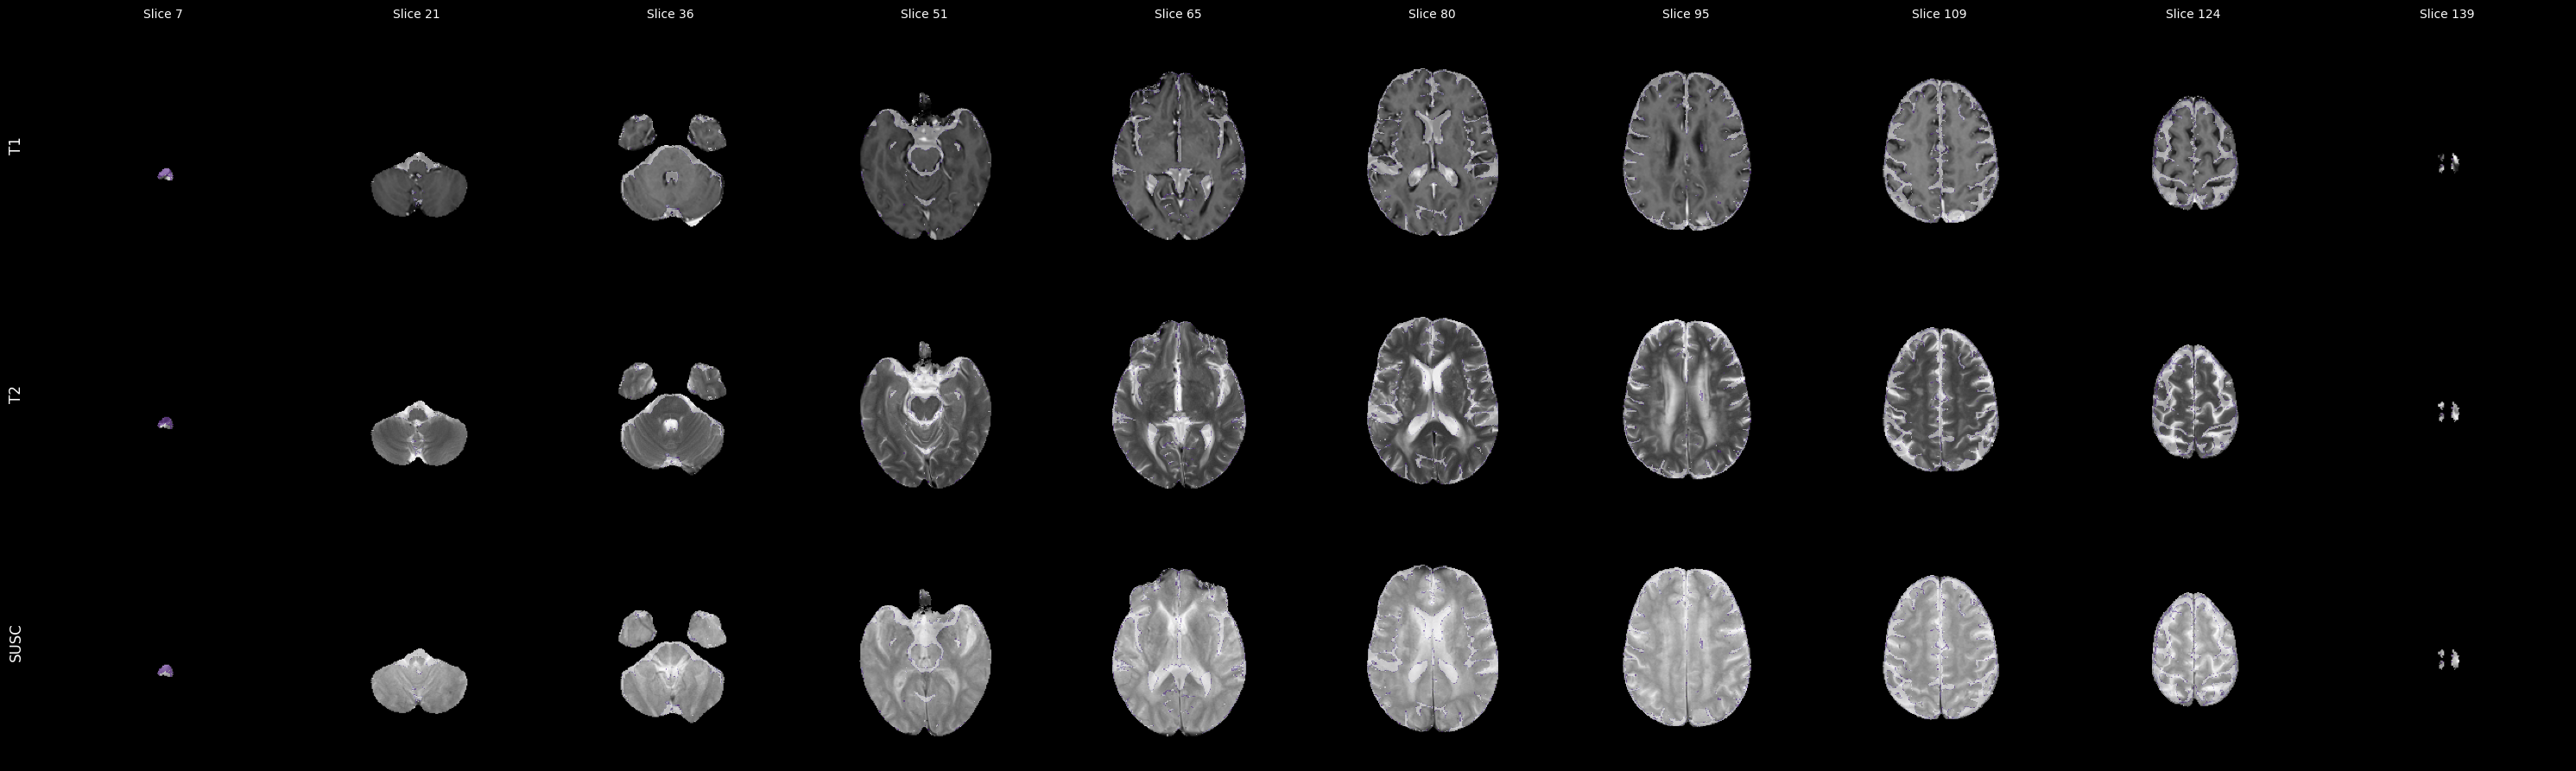

'Saved to /home/mariopasc/Python/Datasets/Meningiomas/assets/axial_slices_P1_no_mask_csf.png'

In [80]:
import matplotlib.pyplot as plt
import numpy as np
import os
import nibabel as nib

def plot_axial_slices(patient_id="P40", n_slices=5, mask=True, white=False, grey=False, csf=False):
    """
    Generate a 3×N plot showing multiple axial slices of a patient with one pulse per row.
    
    Args:
        patient_id: Patient identifier
        n_slices: Number of axial slices to display
        mask: Whether to overlay the tumor segmentation mask
        white: Whether to overlay white matter regions
        grey: Whether to overlay grey matter regions
        csf: Whether to overlay CSF regions
    """
    # Paths
    PATH = "/home/mariopasc/Python/Datasets/Meningiomas/meningioma"
    ATLAS_PATH = "/home/mariopasc/Python/Datasets/Meningiomas/ATLAS/sri24_spm8/tpm"
    ASSETS_PATH = "/home/mariopasc/Python/Datasets/Meningiomas/assets"
    PULSES = ["T1", "T2", "SUSC"]
    
    # Load patient data
    data = {}
    for pulse in PULSES:
        file = os.path.join(PATH, patient_id, f"{pulse}_{patient_id}.nii.gz")
        seg_file = os.path.join(PATH, patient_id, f"{pulse}_{patient_id}_seg.nii.gz")
        img = nib.load(file)
        seg = nib.load(seg_file)

        data[pulse] = {
            "vol": img.get_fdata(),
            "seg": seg.get_fdata(),
        }
    
    # Load tissue maps if needed
    tissue_maps = {}
    if white or grey or csf:
        # Create a descriptive string for output filename
        overlay_str = ""
        
        if white:
            white_img = nib.load(os.path.join(ATLAS_PATH, "white.nii"))
            tissue_maps["white"] = white_img.get_fdata()
            overlay_str += "_white"
            print("Loaded white matter map")
        
        if grey:
            grey_img = nib.load(os.path.join(ATLAS_PATH, "grey.nii"))
            tissue_maps["grey"] = grey_img.get_fdata()
            overlay_str += "_grey"
            print("Loaded grey matter map")
        
        if csf:
            csf_img = nib.load(os.path.join(ATLAS_PATH, "csf.nii"))
            tissue_maps["csf"] = csf_img.get_fdata()
            overlay_str += "_csf"
            print("Loaded CSF map")
    else:
        overlay_str = "_no_overlay"
    
    # Get volume dimensions
    vol_shape = data[PULSES[0]]["vol"].shape
    
    # Calculate evenly spaced slice indices
    z_start = int(vol_shape[2] * 0.05)  # Start at 5% of volume
    z_end = int(vol_shape[2] * 0.9)     # End at 90% of volume
    slice_indices = np.linspace(z_start, z_end, n_slices, dtype=int)
    
    # Create figure
    fig, axes = plt.subplots(len(PULSES), n_slices, figsize=(n_slices * 3, len(PULSES) * 3))
    fig.patch.set_facecolor('black')
    
    # For each pulse (row)
    for row, pulse in enumerate(PULSES):
        vol = data[pulse]["vol"]
        seg = data[pulse]["seg"]
        
        # Normalize volume data for better visualization
        vol_norm = (vol - np.min(vol)) / (np.max(vol) - np.min(vol))
        
        # For each slice (column)
        for col, slice_idx in enumerate(slice_indices):
            ax = axes[row, col]
            
            # Display axial slice
            ax.imshow(np.rot90(vol_norm[:, :, slice_idx]), cmap='gray')
            
            # Overlay segmentation mask for tumor if requested
            if mask:
                ax.imshow(np.rot90(np.ma.where(seg[:, :, slice_idx] == 1, 1, np.nan)), 
                         cmap='Reds_r', alpha=0.5)
            
            # Overlay tissue maps if available
            # We'll use different colors for each tissue type
            if "white" in tissue_maps:
                # Normalize and threshold the tissue map
                white_slice = tissue_maps["white"][:, :, slice_idx]
                white_slice = (white_slice - np.min(white_slice)) / (np.max(white_slice) - np.min(white_slice))
                white_slice = np.ma.masked_where(white_slice < 0.5, white_slice)  # Threshold at 0.5
                ax.imshow(np.rot90(white_slice), cmap='Blues_r', alpha=0.5, interpolation='none')
            
            if "grey" in tissue_maps:
                grey_slice = tissue_maps["grey"][:, :, slice_idx]
                grey_slice = (grey_slice - np.min(grey_slice)) / (np.max(grey_slice) - np.min(grey_slice))
                grey_slice = np.ma.masked_where(grey_slice < 0.5, grey_slice)
                ax.imshow(np.rot90(grey_slice), cmap='Greens_r', alpha=0.5, interpolation='none')
            
            if "csf" in tissue_maps:
                csf_slice = tissue_maps["csf"][:, :, slice_idx]
                csf_slice = (csf_slice - np.min(csf_slice)) / (np.max(csf_slice) - np.min(csf_slice))
                csf_slice = np.ma.masked_where(csf_slice < 0.5, csf_slice)
                ax.imshow(np.rot90(csf_slice), cmap='Purples_r', alpha=0.5, interpolation='none')
            
            # Configure axis
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_facecolor('black')
            
            # Add slice index to first row
            if row == 0:
                ax.set_title(f"Slice {slice_idx}", color='white', fontsize=10)
                
            # Add pulse label to first column
            if col == 0:
                ax.set_ylabel(pulse, color='white', fontsize=12, rotation=90, labelpad=15)
                
            # Set border color
            for spine in ax.spines.values():
                spine.set_color('black')
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.03, hspace=0.03)
    
    # Create a string for the mask option
    mask_str = "_with_mask" if mask else "_no_mask"
    
    # Save figure
    output_file = f"axial_slices_{patient_id}{mask_str}{overlay_str}.png"
    plt.savefig(os.path.join(ASSETS_PATH, output_file), 
                facecolor='black', bbox_inches='tight', dpi=150)
    
    plt.show()
    
    return f"Saved to {os.path.join(ASSETS_PATH, output_file)}"

# Execute the function - showing white and grey matter with mask
plot_axial_slices(patient_id="P1", n_slices=10, mask=False, white=False, grey=False, csf=True)

try tc

In [47]:
def match_intensity_range(reference_volume, target_volume):
    """
    Rescale the intensity values of `target_volume` so that its pixel range 
    (min, max) matches that of `reference_volume`.
    
    Parameters:
        reference_volume (sitk.Image): The reference volume to get the intensity range.
        target_volume (sitk.Image): The volume to be rescaled.
    
    Returns:
        sitk.Image: The target_volume with its intensity rescaled.
    """
    # Get intensity statistics for the reference volume
    ref_stats = sitk.StatisticsImageFilter()
    ref_stats.Execute(reference_volume)
    ref_min = ref_stats.GetMinimum()
    ref_max = ref_stats.GetMaximum()

    # Rescale the target volume's intensities to match the reference intensity range
    adjusted_volume = sitk.RescaleIntensity(target_volume, 
                                              outputMinimum=ref_min, 
                                              outputMaximum=ref_max)
    
    return adjusted_volume

In [98]:
import nrrd
import os
import SimpleITK as sitk

from Meningioma.preprocessing.tools.remove_extra_channels import remove_first_channel
from Meningioma.preprocessing.tools.nrrd_to_nifti import nifti_write_3d
from Meningioma.preprocessing.tools.casting import cast_volume_and_mask
from Meningioma.preprocessing.tools.hu_window import apply_window
from Meningioma.preprocessing.tools.skull_stripping.fsl_bet import fsl_bet_brain_extraction
from Meningioma.preprocessing.tools.registration.ants_registration import register_image_to_sri24

TC_PATH = "/home/mariopasc/Python/Datasets/Meningiomas/Meningioma_Adquisition/TC/P1"

OUT = "/home/mariopasc/Python/Datasets/Meningiomas"

tc_image, hdr = nrrd.read(os.path.join(TC_PATH, "TC_P1.nrrd"))
mask, hdr = nrrd.read(os.path.join(TC_PATH, "TC_P1_seg.nrrd"))
tc_image_hounsfield = apply_window(sitk.GetImageFromArray(tc_image), 
                        window_level=40, 
                        window_width=80, verbose=True)

Applying window with width=80, level=40
  After windowing - Min: 0.0000, Max: 1.0000


Starting enhanced CT brain extraction (smoothing: False, BET FI: 0.01, skull erosion: False)
  Initial thresholding completed in 0.01 seconds
[FSL BET] Running BET with frac=0.01, robust=True, vertical_gradient=0, skull=False
[FSL BET] Completed. Outputs:

inskull_mask_file = <undefined>
inskull_mesh_file = <undefined>
mask_file = /tmp/tmpr1iocvs1/bet_out_mask.nii.gz
meshfile = <undefined>
out_file = /tmp/tmpr1iocvs1/bet_out.nii.gz
outline_file = <undefined>
outskin_mask_file = <undefined>
outskin_mesh_file = <undefined>
outskull_mask_file = <undefined>
outskull_mesh_file = <undefined>
skull_file = <undefined>
skull_mask_file = <undefined>

  BET completed in 16.86 seconds
  Final mask creation completed in 0.69 seconds
  Estimated brain volume: 6787.28 ml


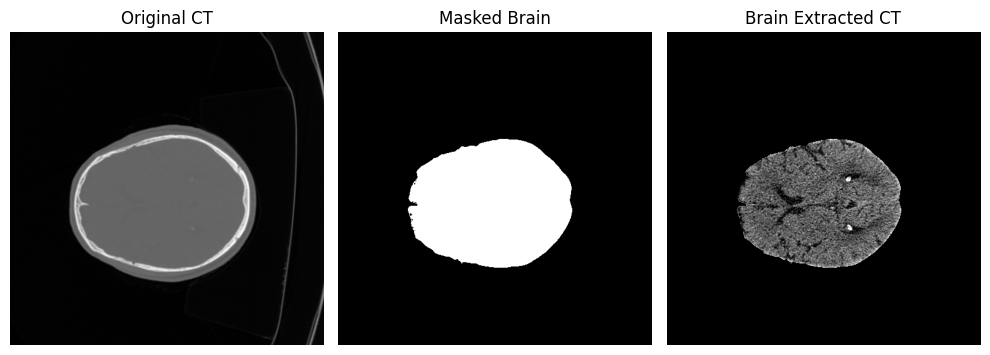

In [109]:
from Meningioma.preprocessing.tools.skull_stripping.ct_bet import ct_brain_extraction

_, masked_brain = ct_brain_extraction(image_sitk=sitk.GetImageFromArray(tc_image), verbose=True)

# Multiply the CT image with the binary mask
be_ct = sitk.Multiply(
    sitk.Cast(tc_image_hounsfield, sitk.sitkFloat32), 
    sitk.Cast(masked_brain, sitk.sitkFloat32)
)

_, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(tc_image[:, :, 130], cmap='gray')
axes[0].set_title("Original CT")
axes[0].axis('off')
axes[1].imshow(sitk.GetArrayFromImage(masked_brain)[:, :, 130], cmap='gray')
axes[1].set_title("Masked Brain")
axes[1].axis('off')
axes[2].imshow(sitk.GetArrayFromImage(be_ct)[:, :, 130], cmap='gray')
axes[2].set_title("Brain Extracted CT")
axes[2].axis('off')
plt.tight_layout()
plt.show()

In [111]:
atlas = "/home/mariopasc/Python/Datasets/Meningiomas/ATLAS/sri24_spm8/templates/T1_brain.nii"
atlas_image = sitk.ReadImage(atlas)
atlas_array = sitk.GetArrayFromImage(atlas_image)

be_ct_matched = match_intensity_range(reference_volume=atlas_image, target_volume=be_ct)

tc_image_registered, mask, transforms = register_image_to_sri24(moving_image=be_ct_matched, moving_mask=sitk.GetImageFromArray(mask), 
                                   config_path="/home/mariopasc/Python/Projects/Meningioma/src/Meningioma/preprocessing/configs/tc_registration_sri24.yaml",
                                   verbose=True)

KeyboardInterrupt: 

(155, 240, 240)


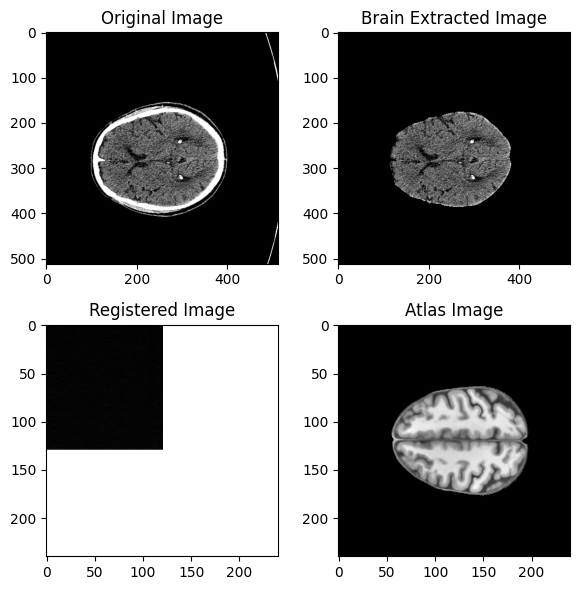

In [106]:
import matplotlib.pyplot as plt
import numpy as np

original_array = sitk.GetArrayFromImage(tc_image_hounsfield)
registered_array = sitk.GetArrayFromImage(tc_image_registered)
be_ct_array = sitk.GetArrayFromImage(be_ct)

print(registered_array.shape)

slice = 130

_, axes = plt.subplots(2, 2, figsize=(6, 6))
axes[0,0].imshow(original_array[:, :, slice], cmap='gray')
axes[0,0].set_title("Original Image")
axes[0,1].imshow(be_ct_array[:, :, slice], cmap='gray')
axes[0,1].set_title("Brain Extracted Image")
axes[1,0].imshow(registered_array[slice, :, :], cmap='gray')
axes[1,0].set_title("Registered Image")
axes [1,1].imshow(np.rot90(atlas_array[110, :, :], 3), cmap='gray')
axes[1,1].set_title("Atlas Image")
plt.tight_layout()
plt.show()

